# En lugar de usar bandido multibrazo realizamos un test no paramétrico (Prueba de permutación).

In [93]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from itertools import combinations

In [94]:
#Chequear que la tasa de conversion de cada estilo coincida con el ejemplo del MAB
#Jugar con distintos valores para validar la teoría
styles = {
    "A": 0.2,
    "B": 0.5,
    "C": 0.2
}

visitas = 3000
visitas_por_estilo = visitas // len(styles)
df_t = pd.DataFrame({
    "variante": styles.keys(),
    "visitas": [visitas_por_estilo] * len(styles),
    "conversiones": [int(v * visitas_por_estilo) for v in styles.values()]
})


In [95]:
# Generar datos simulados
rng = np.random.default_rng(42)

filas = []
for estilo, p in styles.items():
    # Genera 1000 valores 0/1 con probabilidad p
    conversiones = rng.choice([1, 0], size=visitas_por_estilo, p=[p, 1 - p])
    df_estilo = pd.DataFrame({
        "style": estilo,
        "converted": conversiones
    })
    filas.append(df_estilo)

df = pd.concat(filas, ignore_index=True)

print(df.head(10))
print("\nResumen por estilo:")
print(df.groupby("style")["converted"].mean())

  style  converted
0     A          0
1     A          0
2     A          0
3     A          0
4     A          1
5     A          0
6     A          0
7     A          0
8     A          1
9     A          0

Resumen por estilo:
style
A    0.218
B    0.505
C    0.208
Name: converted, dtype: float64


¿El estilo B es mas conveniente? ¿Es estadisticamente creible?

La hipótesis nula las conversiones no dependen del estilo del sitio. Entonces, si mezclas aleatoriamente los valores de conversión entre los estilos, las diferencias de medias deberían parecerse a las que ves.

In [96]:
# Diferencia real de tasas promedio
real_means = df.groupby('style')['converted'].mean()
real_stat = real_means.max() - real_means.min()
print(real_means, real_stat)


style
A    0.218
B    0.505
C    0.208
Name: converted, dtype: float64 0.29700000000000004


Hipotesis nula: no hay diferencias entre los sitios

Diferencia real: 0.297, p-valor: 0.0000


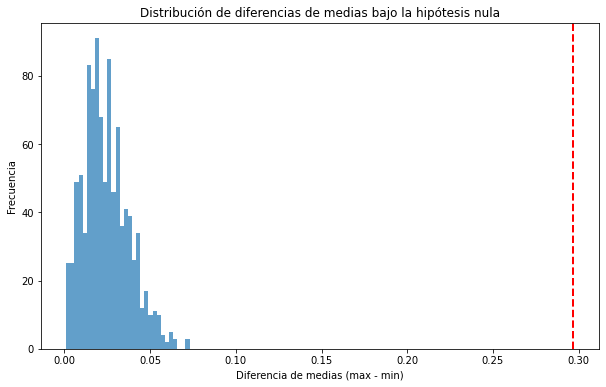

In [97]:

# Permutaciones
n_permutations = 1000
stats = np.zeros(n_permutations)
df_s = df.copy()
for i in range(n_permutations):
    shuffled = df_s['converted'].sample(frac=1, replace=False).to_numpy()
    df_s['shuffled'] = shuffled
    means = df_s.groupby('style')['shuffled'].mean()
    stats[i] = means.max() - means.min()

# p-value: proporción de permutaciones con diferencia >= real
p_value = np.mean(stats >= real_stat)
print(f"Diferencia real: {real_stat:.3f}, p-valor: {p_value:.4f}")
plt.figure(figsize=(10, 6))
plt.hist(stats, bins=30, alpha=0.7)
plt.axvline(real_stat, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribución de diferencias de medias bajo la hipótesis nula')
plt.xlabel('Diferencia de medias (max - min)')
plt.ylabel('Frecuencia')    
plt.show()

Ahora deberíamos ver cual es el mejor...

Analizamos de a pares

In [98]:
for a, b in combinations(df['style'].unique(), 2):
    sub = df_s.loc[df_s['style'].isin([a, b]), :]
    real_diff = sub.groupby('style')['converted'].mean().diff().iloc[-1]
    
    stats = np.zeros(n_permutations)
    for i in range(n_permutations):
        shuffled = sub.loc[:,['converted']].sample(frac=1, replace=False).to_numpy()
        sub.loc[:,['shuffled']] = shuffled
        diff = sub.groupby('style')['shuffled'].mean().diff().iloc[-1]
        stats[i] = diff

    p_val = np.mean(np.abs(stats) >= abs(real_diff))
    print(f"{a} vs {b}: diff={real_diff:.3f}, p={p_val:.4f}")


A vs B: diff=0.287, p=0.0000
A vs C: diff=-0.010, p=0.6290
B vs C: diff=-0.297, p=0.0000
